In [2]:
#!pip install pytorch-lightning

In [3]:
#!pip install neptune-client

In [4]:
#!pip install opencv-python

https://pytorch.org/vision/stable/models.html

https://pytorch.org/vision/stable/transforms.html

Импортируем необходимые модули.

In [6]:
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision
import torchvision.models as models
import pytorch_lightning as pl
import torch.nn as nn
from torchmetrics import Accuracy
import torch.optim as optim
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from collections import Counter
from PIL import Image

/Users/mark/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

Данные можно взять отсюда - https://www.kaggle.com/datasets/muhammadardiputra/potato-leaf-disease-dataset.

In [7]:
CONFIG = {"lr":2*1e-4,\
         "batch_size":32,\
         'epochs':10}

Пайплайн аугментаций.

In [8]:
train_transforms = transforms.Compose([transforms.Resize(size=224),
              transforms.RandomHorizontalFlip(),
              transforms.RandomVerticalFlip(),
              transforms.CenterCrop(size=224),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
val_transforms = transforms.Compose([
              transforms.Resize(size=224),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])


In [9]:
train_ds = ImageFolder('./dataset/PLD_3_Classes_256/Training/',transform=train_transforms)
val_ds = ImageFolder('./dataset/PLD_3_Classes_256/Validation/',transform=val_transforms)
test_ds = ImageFolder('./dataset/PLD_3_Classes_256/Testing/',transform=val_transforms)

In [10]:
train_cnt = Counter(train_ds.targets)
val_cnt = Counter(val_ds.targets)
test_cnt = Counter(test_ds.targets)
print(train_cnt)
print(val_cnt)
print(test_cnt)

Counter({0: 1303, 2: 1132, 1: 816})
Counter({0: 163, 2: 151, 1: 102})
Counter({0: 162, 2: 141, 1: 102})


In [11]:
train_dl = DataLoader(train_ds, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=4)
test_dl = DataLoader(test_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=4)

In [12]:
id2clas = {i:q for q,i in train_ds.class_to_idx.items()}

Визуализируем.

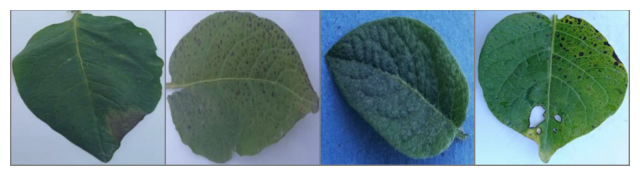

['Late_Blight', 'Early_Blight', 'Healthy', 'Early_Blight']


In [13]:
NUM_IMAGES = 4
samples = [train_ds[idx] for idx in np.random.randint(0,len(train_ds),4)]
images = [i[0] for i in samples]
labels = [id2clas[i[1]] for i in samples]

img_grid = torchvision.utils.make_grid(images, nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()
print(labels)

# Model

In [14]:
class LeafModel(pl.LightningModule):
    def __init__(self, num_classes, lr=2e-4):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr
        self.num_classes = num_classes
        self.model = models.resnet50(pretrained=True)
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 128),
            nn.Dropout(0.3),
            nn.Linear(128, self.num_classes)
        )
        
        self.loss_fn = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=3)
        
    def forward(self, x):
        x = self.model(x)
        return x
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2)
        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_idx):
        
        x, y = batch
        
        preds = self(x)
        loss = self.loss_fn(preds, y)
        acc = self.accuracy(torch.argmax(preds, dim=1), y)
        
        self.log('train_loss', loss.item(), on_epoch=True,logger=True)
        self.log('train_acc', acc, on_epoch=True,logger=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        
        x,y = batch
        
        preds = self(x)
        
        loss = self.loss_fn(preds, y)
        acc = self.accuracy(torch.argmax(preds, dim=1), y)
        
        self.log('val_loss', loss, on_epoch=True,prog_bar=True,logger=True)
        self.log('val_acc', acc, on_epoch=True,prog_bar=True,logger=True)
        
    def test_step(self, batch, batch_idx):
        
        x,y = batch
        preds = self(x)
        acc = self.accuracy(torch.argmax(preds, dim=1), y)
        
        self.log('test_acc', acc, on_epoch=True,prog_bar=True)

# Train and eval

Я использовал neptune.ai в качестве логгера (но можно и популярный wandb или стандартный tensorboard).

In [17]:
from pytorch_lightning.loggers import NeptuneLogger

neptune_logger = NeptuneLogger(
   project="leaf-classifier",#"<PROJECT_NAME>",
   api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhNzgyN2Q3OC05ZWE5LTRkZGQtODUyOS03ZmYzNGQwOTczYTEifQ==",#"<YOUR_API_KEY>",
   tags=["training", "resnet50"]
)

checkpoint_callback = ModelCheckpoint(dirpath='./resnet-potato/',filename='best', monitor='val_loss',mode='min', save_top_k=1)
model = LeafModel(num_classes = 3,lr = CONFIG['lr'])
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.001, patience=3, verbose=False, mode="min")
trainer_args = {
        "accelerator": "gpu",
        "max_epochs": CONFIG['epochs'],
        "callbacks": [early_stop_callback,checkpoint_callback],
    }
trainer = pl.Trainer(**trainer_args,logger = neptune_logger,default_root_dir='./resnet-potato/',enable_progress_bar=True)
trainer.fit(model,train_dl,val_dl)

[neptune] [warning] NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
[neptune] [warning] NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
/Users/mark/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mark/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weig

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/markpotanin/leaf-classifier/e/LEAF-9



  | Name     | Type               | Params
------------------------------------------------
0 | model    | ResNet             | 23.8 M
1 | loss_fn  | CrossEntropyLoss   | 0     
2 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
23.8 M    Trainable params
0         Non-trainable params
23.8 M    Total params
95.083    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/mark/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:07<00:07,  0.14it/s]

/Users/mark/miniconda3/lib/python3.10/site-packages/torchmetrics/functional/classification/accuracy.py:77: UserWarning: MPS: no support for int64 reduction ops, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/ReduceOps.mm:144.)
  tp = tp.sum(dim=0 if multidim_average == "global" else 1)


/Users/mark/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 5:  34%|███▍      | 35/102 [00:34<01:05,  1.03it/s, v_num=AF-9, val_loss=0.00978, val_acc=0.995] [neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 203.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 305.0
Epoch 7:  70%|██████▉   | 71/102 [00:45<00:20,  1.55it/s, v_num=AF-9, val_loss=0.00795, val_acc=0.998] [neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 407.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 509.0
Epoch 8: 100%|██████████| 102/102 [01:15<00:00,  1.35i

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 611.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 713.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 815.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 917.0


In [18]:
metrics = trainer.logged_metrics

In [19]:
metrics

{'train_loss_step': tensor(0.0018),
 'train_acc_step': tensor(1.),
 'val_loss': tensor(0.0085),
 'val_acc': tensor(0.9976),
 'train_loss_epoch': tensor(0.0105),
 'train_acc_epoch': tensor(0.9972)}

In [20]:
trainer.test(model, test_dl)

/Users/mark/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 13/13 [00:01<00:00,  9.08it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9925925731658936     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9925925731658936}]